## GReaT Example with Iris Dataset

In [3]:
# Execute only once!
import os
import sys
sys.path.append("..")
os.chdir("..")

os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [4]:
import numpy as np
import pandas as pd
import logging
from sklearn import datasets
from examples.utils import set_logging_level
from be_great import GReaT
import matplotlib.pyplot as plt

logger = set_logging_level(logging.INFO)

### Load Data

In [5]:
data = datasets.load_iris(as_frame=True).frame
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [6]:
len(data)

150

In [7]:
data.columns = ["sepal length", "sepal width", "petal length", "petal width", "target"]

### Create GReaT Model

In [11]:
great = GReaT("/home/wangshuyue/pretrainedModels_and_archivedFiles_and_stuffs/distilgpt2",                  # Name of the large language model used (see HuggingFace for more options)
              epochs=1000,                   # Number of epochs to train
              save_steps=2000,               # Save model weights every x steps
              logging_steps=500,             # Log the loss and learning rate every x steps
              experiment_dir="trainer_iris", # Name of the directory where all intermediate steps are saved
              batch_size=16,                 # Batch Size
              #lr_scheduler_type="constant", # Specify the learning rate scheduler 
              #learning_rate=5e-5            # Set the inital learning rate
             )

### Start Training

In [12]:
trainer = great.fit(data)

2024-07-31 16:00:07,674 - INFO - Convert data into HuggingFace dataset object... (great.py:153)
2024-07-31 16:00:07,674 - INFO - Convert data into HuggingFace dataset object... (great.py:153)
2024-07-31 16:00:07,694 - INFO - Create GReaT Trainer... (great.py:158)
2024-07-31 16:00:07,694 - INFO - Create GReaT Trainer... (great.py:158)
2024-07-31 16:00:09,134 - WARNING - Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher. (other.py:349)
2024-07-31 16:00:09,134 - WARNING - Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher. (other.py:349)
2024-07-31 16:00:14,416 - INFO - Start training... (great.py:174)
2024-07-31 16:00:14,416 - INFO - Start training... (great.py:174)
You're using a GPT2TokenizerFast tokenizer. Please

Step,Training Loss
500,0.566600
1000,0.443600
1500,0.414200
2000,0.383200
2500,0.355700
3000,0.336700
3500,0.323700
4000,0.315400
4500,0.307800
5000,0.302500


In [13]:
loss_hist = trainer.state.log_history.copy()
loss_hist.pop()

{'train_runtime': 428.2894,
 'train_samples_per_second': 350.23,
 'train_steps_per_second': 23.349,
 'total_flos': 1339656192000000.0,
 'train_loss': 0.3320571823120117,
 'epoch': 1000.0,
 'step': 10000}

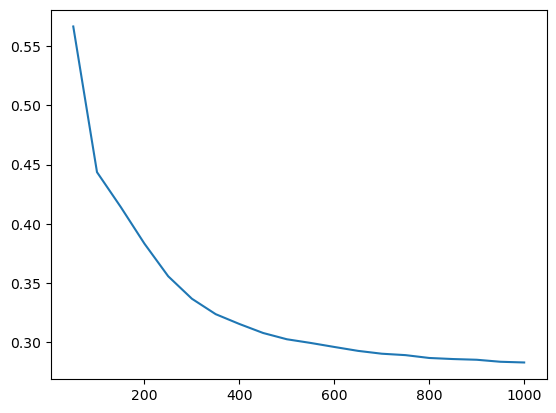

In [14]:
loss = [x["loss"] for x in loss_hist]
epochs = [x["epoch"] for x in loss_hist]
plt.plot(epochs, loss)

### Save Model

In [15]:
great.save("iris")

### Load Model

In [11]:
great = GReaT.load_from_dir("iris")

### Generate Samples

In [16]:
n_samples = 150
samples = great.sample(n_samples, k=50)
samples

100%|██████████| 150/150 [00:02<00:00, 71.16it/s]


,sepal length,sepal width,petal length,petal width,target
0,5.8,2.8,5.1,2.4,2.0
1,6.0,2.2,4.0,1.0,1.0
2,4.9,3.0,1.4,0.2,0.0
3,6.5,3.0,5.1,2.0,2.0
4,5.0,2.3,3.3,1.0,1.0
...,...,...,...,...,...
145,6.8,3.1,5.5,2.1,2.0
146,6.3,2.3,4.4,1.3,1.0
147,6.2,2.8,4.8,1.8,2.0
148,6.5,3.0,5.2,2.0,2.0


In [17]:
samples.to_csv("iris_samples.csv")

We can also influence the distribution of the column on which the generation is conditioned (In the original dataset all three target values (0, 1, 2) have a probability of 33%).

In [16]:
samples_custom = great.sample(n_samples, k=50, start_col="target",
                              start_col_dist={"0": 0.5, "1": 0.5, "2": 0})

100%|██████████| 150/150 [00:02<00:00, 74.23it/s]


In [17]:
samples_custom.head()

,sepal length,sepal width,petal length,petal width,target
0,5.4,3.4,1.5,0.4,0.0
1,5.7,2.6,1.4,0.2,0.0
2,5.0,2.0,3.5,1.0,1.0
3,5.3,3.7,1.5,0.2,0.0
4,5.1,2.5,3.0,1.1,1.0


## Plot Data

Original Data

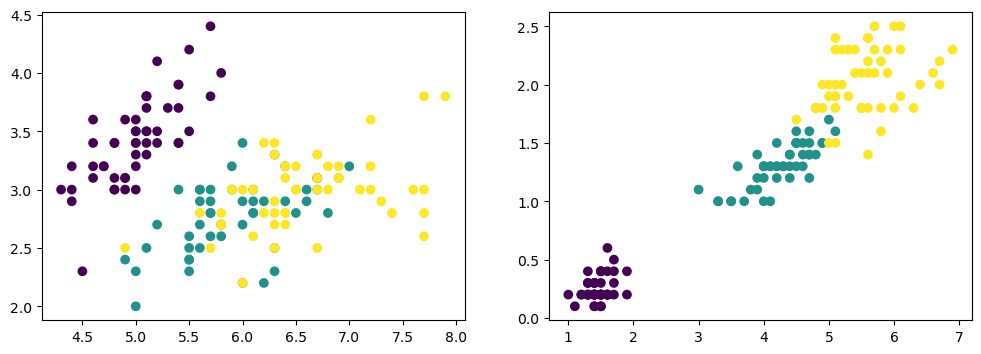

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].scatter(data["sepal length"], data["sepal width"], c=data["target"])
ax[1].scatter(data["petal length"], data["petal width"], c=data["target"])

Generated samples

In [ ]:
samples = pd.read_csv("iris_samples.csv")

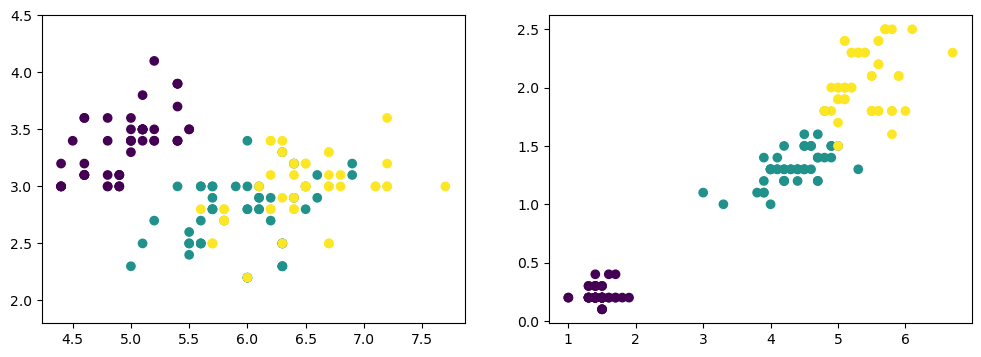

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].scatter(samples["sepal length"], samples["sepal width"], c=samples["target"].astype("int"))
ax[0].set_ylim(1.8, 4.5)
ax[1].scatter(samples["petal length"], samples["petal width"], c=samples["target"].astype("int"))

Let me, as a final attempt, show you an example of sample imputing 

In [33]:
for clm in data.columns:
    data[clm]=data[clm].apply(lambda x: (x if np.random.rand() > 0.25 else np.nan))

data

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,NaN,0.2,0.0
1,4.9,3.0,1.4,NaN,0.0
2,4.7,3.2,NaN,0.2,0.0
3,4.6,3.1,1.5,NaN,0.0
4,5.0,NaN,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,NaN,NaN,5.2,2.0,NaN
148,NaN,3.4,NaN,2.3,2.0


In [34]:
imputed_data = great.impute(data, max_length=200)
imputed_data

100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.7,3.4,5.2,2.3,2.0
